In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best-model/my_dl_model_7.keras
/kaggle/input/output/output1 (2).csv
/kaggle/input/binance-spot-btcusdt-1m-from-2017-08-to-2023-03/BTCUSDT-1m-2017-08-to-2023-03 (Binance SPOT).csv
/kaggle/input/mymodel/my_dl_model_2.keras
/kaggle/input/better-dl-models/my_dl_model_4.keras
/kaggle/input/better-dl-models/my_dl_model_5.keras
/kaggle/input/btcusdt-different-timeframes/BTCUSDT-1h.csv
/kaggle/input/btcusdt-different-timeframes/BTCUSDT-2h.csv
/kaggle/input/btcusdt-different-timeframes/BTCUSDT-3m.csv
/kaggle/input/btcusdt-different-timeframes/BTCUSDT-1Month.csv
/kaggle/input/btcusdt-different-timeframes/BTCUSDT-1w.csv
/kaggle/input/btcusdt-different-timeframes/BTCUSDT-15m.csv
/kaggle/input/btcusdt-different-timeframes/BTCUSDT-1m.csv
/kaggle/input/btcusdt-different-timeframes/BTCUSDT-6h.csv
/kaggle/input/btcusdt-different-timeframes/BTCUSDT-3d.csv
/kaggle/input/btcusdt-different-timeframes/BTCUSDT-12h.csv
/kaggle/input/btcusdt-different-timeframes/BTCUSDT-4h.csv
/kaggle/input/btcus

# Reading data from CSV

In [2]:
data=pd.read_csv('/kaggle/input/all-given-data-on-btcusd/btc_5m.csv')

In [3]:
# output=pd.read_csv('/kaggle/input/output/output1 (2).csv')
# from collections import Counter
# print(Counter(output['signals']))

In [4]:
data.tail()

,datetime,open,high,low,close,volume
427809,2022-01-31 05:10:00,37950.55,37979.31,37875.58,37959.87,119.16408
427810,2022-01-31 05:15:00,37959.87,37959.88,37876.94,37896.41,73.05197
427811,2022-01-31 05:20:00,37896.41,37948.79,37870.00,37928.03,41.39523
427812,2022-01-31 05:25:00,37928.04,37945.25,37870.00,37881.76,57.85144
427813,2022-01-31 05:30:00,37881.75,37951.07,37869.98,37872.66,98.33909


In [5]:
#setting index of dataFrame to CSV
data.index = pd.to_datetime(data['datetime'],format="%Y-%m-%d %H:%M:%S")

In [6]:
def add_lags(df):
    df['high_lag'] = df['high'].shift(1)
    df['low_lag'] = df['low'].shift(1)
    df['close_lag'] = df['close'].shift(1)
    df['volume_lag'] = df['volume'].shift(1)
    return df

#Calculation of moving average
def ma(df, n):
    return pd.Series(df.rolling(n, min_periods=n).mean(), name='MA_' + str(n))

# exponentially weighted moving average 
def ema(df, n):
    return pd.Series(df.ewm(span=n,min_periods=n).mean(), name='EMA_' + str(n))

#Calculation of price momentum
def mom(df, n):     
    return pd.Series(df.diff(n), name='Momentum_' + str(n))  

# rate of change
def roc(df, n):  
    M = df.diff(n - 1) ; N = df.shift(n - 1)  
    return pd.Series(((M / N) * 100), name = 'ROC_' + str(n)) 

# relative strength index
def rsi(df, period):
    delta = df.diff().dropna()
    u = delta * 0; d = u.copy()
    u[delta > 0] = delta[delta > 0]; d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

# stochastic oscillators slow & fast
def sto(close, low_lag, high_lag, n,id): 
    stok = ((close - low_lag.rolling(n).min()) / (high_lag.rolling(n).max() - low_lag.rolling(n).min())) * 100
    if(id == 0):
        return stok
    else:
        return stok.rolling(3).mean()
    
#Bollinger_Bands
def bbands(df, n = 30, numsd = 2):
    """ returns average, upper band, and lower band"""
    #ave = pd.stats.moments.rolling_mean(price,length)
    ave = df.rolling(window = n, center = False).mean()
    #sd = pd.stats.moments.rolling_std(price,length)
    sd = df.rolling(window = n, center = False).std()
    
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

#Aroon_Oscillator
def aroon(df, tf = 25):
    aroonup = []
    aroondown = []
    x = tf
    
    while x< len(df.index):
        aroon_up = ((df['high_lag'][x-tf:x].tolist().index(max(df['high_lag'][x-tf:x])))/float(tf))*100
        aroon_down = ((df['low_lag'][x-tf:x].tolist().index(min(df['low_lag'][x-tf:x])))/float(tf))*100
        aroonup.append(aroon_up)
        aroondown.append(aroon_down)
        x+=1
    
    return aroonup, aroondown

#Acceleration_Bands
def abands(df):
    
    #df['AB_Middle_Band'] = pd.rolling_mean(df['Close'], 20)
    df['AB_Middle_Band'] = df['open'].rolling(window = 20, center = False).mean()
    
    # High * ( 1 + 4 * (High - Low) / (High + Low))
    df['aupband'] = df['high_lag'] * (1 + 4 * (df['high_lag']-df['low_lag'])/(df['high_lag']+df['low_lag']))
    df['AB_Upper_Band'] = df['aupband'].rolling(window=20, center=False).mean()
    
    # Low *(1 - 4 * (High - Low)/ (High + Low))
    df['adownband'] = df['low_lag'] * (1 - 4 * (df['high_lag']-df['low_lag'])/(df['high_lag']+df['low_lag']))
    df['AB_Lower_Band'] = df['adownband'].rolling(window = 20, center = False).mean()
    
#Chaikin_Money_Flow
def CMFlow(df, tf):
    CHMF = []
    MFMs = []
    MFVs = []
    x = tf
    
    while x < len(df['datetime']):
        PeriodVolume = 0
        volRange = df['volume_lag'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        
        MFM = ((df['open'][x] - df['low_lag'][x]) - (df['high_lag'][x] - df['open'][x])) / (df['high_lag'][x] - df['low_lag'][x])
        MFV = MFM*PeriodVolume
        
        MFMs.append(MFM)
        MFVs.append(MFV)
        x+=1
    
    y = tf
    while y < len(MFVs):
        PeriodVolume = 0
        volRange = df['volume_lag'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        consider = MFVs[y-tf:y]
        tfsMFV = 0
        
        for eachMFV in consider:
            tfsMFV += eachMFV
        
        tfsCMF = tfsMFV/PeriodVolume
        CHMF.append(tfsCMF)
        y+=1
    return CHMF

#Parabolic_SAR
def psar(df, iaf = 0.02, maxaf = 0.2):
    length = len(df)
    high = (df['high_lag'])
    low_lag = (df['low_lag'])
    close = (df['open'])
    psar = df['open'][0:len(df['open'])]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = df['low_lag'][0]
    hp = df['high_lag'][0]
    lp = df['low_lag'][0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if df['low_lag'][i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = df['low_lag'][i]
                af = iaf
        else:
            if df['high_lag'][i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = df['high_lag'][i]
                af = iaf
        if not reverse:
            if bull:
                if df['high_lag'][i] > hp:
                    hp = df['high_lag'][i]
                    af = min(af + iaf, maxaf)
                if df['low_lag'][i - 1] < psar[i]:
                    psar[i] = df['low_lag'][i - 1]
                if df['low_lag'][i - 2] < psar[i]:
                    psar[i] = df['low_lag'][i - 2]
            else:
                if df['low_lag'][i] < lp:
                    lp = df['low_lag'][i]
                    af = min(af + iaf, maxaf)
                if df['high_lag'][i - 1] > psar[i]:
                    psar[i] = df['high_lag'][i - 1]
                if df['high_lag'][i - 2] > psar[i]:
                    psar[i] = df['high_lag'][i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    #return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}
    #return psar, psarbear, psarbull
    df['psar'] = psar
    #df['psarbear'] = psarbear
    #df['psarbull'] = psarbull
  
# Commodity_Channel_Index
def CCI(df, n, constant):
    TP = (df['high_lag'] + df['low_lag'] + df['open']) / 3
    CCI = pd.Series((TP - TP.rolling(window=n, center=False).mean()) / (constant * TP.rolling(window=n, center=False).std())) #, name = 'CCI_' + str(n))
    return CCI

#Keltner Channel  
def KELCH(df, n):  
    KelChM = pd.Series(((df['high_lag'] + df['low_lag'] + df['open']) / 3).rolling(window = n, center = False).mean(), name = 'KelChM_' + str(n))  
    KelChU = pd.Series(((4 * df['high_lag'] - 2 * df['low_lag'] + df['open']) / 3).rolling(window = n, center = False).mean(), name = 'KelChU_' + str(n))  
    KelChD = pd.Series(((-2 * df['high_lag'] + 4 * df['low_lag'] + df['open']) / 3).rolling(window = n, center = False).mean(), name = 'KelChD_' + str(n))    
    
    return KelChM, KelChD, KelChU

#ATR
def ATR(df,n):
    df['HL'] = df['high_lag'] - df['low_lag']
    df['absHC'] = abs(df['high_lag'] - df['open'].shift(1))
    df['absLC'] = abs(df['low_lag'] - df['open'].shift(1))
    df['TR'] = df[['HL','absHC','absLC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=14).mean()
    df['NATR'] = (df['ATR'] / df['open']) *100

#Adaptive_Moving_Average
def KAMA(prices, n=10, pow1=2, pow2=30):
    
    absDiffx = abs(prices - prices.shift(1) )  

    ER_num = abs( prices - prices.shift(n) )
    ER_den = absDiffx.rolling(window=n,center=False).sum()
    ER = ER_num / ER_den

    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0


    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True

    for i in range(N):
        if sc[i] != sc[i]:
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = prices[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (prices[i] - answer[i-1])
    return answer

#William_%R
def WillR(df):
    highest_high = df['high_lag'].rolling(window=14,center=False).max()
    lowest_low = df['low_lag'].rolling(window=14,center=False).min()
    df['WillR'] = (-100) * ((highest_high - df['open']) / (highest_high - lowest_low))

# Creating Features to analyze tha data

In [7]:
def create_features(df):
    df = df.copy()
    
    df=add_lags(df);
    df=df.dropna()
    
    df['MA_10']=ma(df['open'],10)
    df['MA_30']=ma(df['open'],30)
    df['Feature1']=df['MA_10']/df['open']
    df['Feature2']=df['MA_30']/df['open']
    df['Feature3']=(df['MA_10']-df['MA_30'])/df['open']
    
    df['EMA_10']=ema(df['open'],10)
    df['EMA_30']=ema(df['open'],30)
    df['Feature4']=df['EMA_10']/df['open']
    df['Feature5']=df['EMA_30']/df['open']
    df['Feature6']=(df['EMA_10']-df['EMA_30'])/df['open']
    
    df['ROC_10']=roc(df['open'],10)
    
    df['RSI_14']=rsi(df['open'],14)
    df['RSI_MA_10']=ma(df['RSI_14'],10)
    
    df['STOK']=sto(df['open'],df['low_lag'], df['high_lag'], 15, 0)
    df['STOK_ROLL']=sto(df['open'],df['low_lag'], df['high_lag'], 15, 1)
    
#     Bollinger_Bands
    df['BB_Middle_Band'], df['BB_Upper_Band'], df['BB_Lower_Band'] = bbands(df['open'], n=20, numsd=1)
    df['Feature7']=(df['BB_Upper_Band']-df['BB_Middle_Band'])/df['open']
    df['Feature8']=(df['BB_Middle_Band']-df['BB_Lower_Band'])/df['open']
    df['Feature9']=(df['BB_Upper_Band']-df['BB_Lower_Band'])/df['open']
    df['Feature10']=(df['BB_Upper_Band'])/df['open']
    df['Feature11']=(df['BB_Middle_Band'])/df['open']
    df['Feature12']=(df['BB_Upper_Band'])/df['open']
    
    #Aroon Oscillator
    listofzeros = [0] * 25
    up, down = aroon(df)
    aroon_list = [x - y for x, y in zip(up,down)]

    if len(aroon_list) == 0:
        aroon_list = [0] * df.shape[0]
        df['Aroon_Oscillator'] = aroon_list

    else:
        df['Aroon_Oscillator'] = listofzeros+aroon_list
        
    #Acceleration_Bands
    abands(df)
    
    #Chaikin_Money_Flow
    listofzeros = [0] * 40
    CHMF = CMFlow(df, 20)

    if len(CHMF)==0:
        CHMF = [0] * df.shape[0]
        df['Chaikin_MF'] = CHMF

    else:
        df['Chaikin_MF'] = listofzeros + CHMF
    
    #Parabolic_SAR    
    psar(df)
    df['Feature13']=df['psar']/df['open']
    #Commodity_Channel_Index
    df['CCI'] = CCI(df, 20, 0.015)
    
    #Kelter_Channel
    KelchM, KelchD, KelchU = KELCH(df, 14)
    df['Kelch_Upper'] = KelchU
    df['Kelch_Middle'] = KelchM
    df['Kelch_Down'] = KelchD
    df['Feature17']= (df['Kelch_Upper']-df['Kelch_Middle'])/df['open']
    df['Feature18']= (df['Kelch_Upper']-df['Kelch_Down'])/df['open']
    df['Feature19']= (df['Kelch_Middle']-df['Kelch_Down'])/df['open']
    #ATR
    ATR(df,15)

    #William_%R
    WillR(df)
    
    Features=['AB_Middle_Band', 'aupband', 'AB_Upper_Band',
       'adownband', 'AB_Lower_Band']
    
    df['Feature20']= (df['AB_Upper_Band']-df['AB_Middle_Band'])/df['open']
    df['Feature21']= (df['AB_Upper_Band']-df['AB_Lower_Band'])/df['open']
    df['Feature22']= (df['AB_Middle_Band']-df['AB_Lower_Band'])/df['open']
    df['Feature23']= (df['aupband']-df['adownband'])/df['open']
    
    return df

In [8]:
data=create_features(data)

/tmp/ipykernel_42/3605539727.py:100: RuntimeWarning: invalid value encountered in scalar divide
  MFM = ((df['open'][x] - df['low_lag'][x]) - (df['high_lag'][x] - df['open'][x])) / (df['high_lag'][x] - df['low_lag'][x])
/tmp/ipykernel_42/3605539727.py:100: RuntimeWarning: divide by zero encountered in scalar divide
  MFM = ((df['open'][x] - df['low_lag'][x]) - (df['high_lag'][x] - df['open'][x])) / (df['high_lag'][x] - df['low_lag'][x])


In [9]:
def create_more_features(df):
    df = df.copy()
    df['Feature14']=df['high_lag']/df['open']
    df['Feature15']=df['low_lag']/df['open']
    df['Feature16']=(df['high_lag']-df['low_lag'])/df['open']
    return df

data = create_more_features(data)

In [10]:
data.dropna(inplace=True)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='ffill', inplace=True)
data.head()

,datetime,open,high,low,close,volume,high_lag,low_lag,close_lag,volume_lag,...,ATR,NATR,WillR,Feature20,Feature21,Feature22,Feature23,Feature14,Feature15,Feature16
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 08:00:00,2018-01-01 08:00:00,13437.245494,13349.99,13200.00,13288.00,40.749234,13330.00,13225.0,13225.00,34.404702,...,272.719959,2.029582,-36.013826,0.020155,0.039401,0.019246,0.039071,0.992019,0.984205,0.007814
2018-01-01 08:05:00,2018-01-01 08:05:00,13414.696255,13340.00,13210.00,13220.00,41.084138,13349.99,13200.0,13288.00,40.749234,...,279.305480,2.082086,-39.640553,0.019629,0.039104,0.019475,0.055905,0.995176,0.983995,0.011181
2018-01-01 08:10:00,2018-01-01 08:10:00,13393.950954,13340.00,13220.00,13321.08,29.886131,13340.00,13210.0,13220.00,41.084138,...,282.102938,2.106197,-41.036812,0.019984,0.039323,0.019340,0.048529,0.995972,0.986266,0.009706
2018-01-01 08:15:00,2018-01-01 08:15:00,13374.865278,13389.00,13320.00,13365.99,43.155417,13340.00,13220.0,13321.08,29.886131,...,280.478106,2.097054,-40.149084,0.019974,0.039942,0.019967,0.044860,0.997393,0.988421,0.008972
2018-01-01 08:20:00,2018-01-01 08:20:00,13155.380000,13418.43,13260.09,13323.02,38.370955,13389.00,13320.0,13365.99,43.155417,...,271.744805,2.065655,-100.000000,0.020123,0.040576,0.020453,0.026225,1.017759,1.012514,0.005245


In [11]:
data.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'high_lag',
       'low_lag', 'close_lag', 'volume_lag', 'MA_10', 'MA_30', 'Feature1',
       'Feature2', 'Feature3', 'EMA_10', 'EMA_30', 'Feature4', 'Feature5',
       'Feature6', 'ROC_10', 'RSI_14', 'RSI_MA_10', 'STOK', 'STOK_ROLL',
       'BB_Middle_Band', 'BB_Upper_Band', 'BB_Lower_Band', 'Feature7',
       'Feature8', 'Feature9', 'Feature10', 'Feature11', 'Feature12',
       'Aroon_Oscillator', 'AB_Middle_Band', 'aupband', 'AB_Upper_Band',
       'adownband', 'AB_Lower_Band', 'Chaikin_MF', 'psar', 'Feature13', 'CCI',
       'Kelch_Upper', 'Kelch_Middle', 'Kelch_Down', 'Feature17', 'Feature18',
       'Feature19', 'HL', 'absHC', 'absLC', 'TR', 'ATR', 'NATR', 'WillR',
       'Feature20', 'Feature21', 'Feature22', 'Feature23', 'Feature14',
       'Feature15', 'Feature16'],
      dtype='object')

# Creating a simple moving window strategy to generate signals for training the model

In [12]:
class MyPair:
    def __init__(self, f, s):
        self.first = f
        self.second = s

def generate_signals(v, fees):
    n = len(v)
    flag = True
    signals = [0] * n
    myPairs = []
    cnt=0;
    # if flag is true, the price is increasing else decreasing.
    i = 0
    while i < n:
        cpy = i

        if flag:
            while cpy + 1 < n and v[cpy + 1] >= v[cpy]:
                myPairs.append(MyPair(v[cpy], cpy))
                cnt +=1
                cpy += 1
            if cpy < n:
                myPairs.append(MyPair(v[cpy], cpy))
                cnt +=1

            flag = False
        else:
            while cpy + 1 < n and v[cpy + 1] <= v[cpy]:
                myPairs.append(MyPair(v[cpy], cpy))
                cnt +=1
                cpy += 1

            if cpy < n:
                myPairs.append(MyPair(v[cpy], cpy))
                cnt +=1

            flag = True
            
        h, l = len(myPairs) - 1, 0
        myPairs.sort(key=lambda x: x.first)

        while h > l:
            sell_price= myPairs[h].first * (1 - fees / 100)
            cost_price= myPairs[l].first * (1 + fees / 100)
            min_profit= 0.03* myPairs[l].first
            if sell_price-cost_price>min_profit:
                signals[myPairs[h].second] = 2
                signals[myPairs[l].second] = 1
            else:
                break

            h -= 1
            l += 1
        
        myPairs=myPairs[l:-l]
        
        if(cnt>12*24*2):
            myPairs=[]
            cnt=0
            k=i-12*24*1
            while(k<i):
                if(signals[k]==0):
                    myPairs.append(MyPair(v[k], k))
                    cnt +=1
                k +=1;
        i = cpy
        i+=1

    return signals

# Example usage
v = [100, 200, 300, 180, 50, 70, 90]
fees = 0.003

signals = generate_signals(v, fees)
print(signals)
print("Complete")

[1, 2, 2, 2, 1, 1, 0]
Complete


In [13]:
train_test_data=data['2019-01-01':'2022-01-01']
back_test_data=data['2022-01-01':]
train=train_test_data[:'2021-05-01']
test=train_test_data['2021-05-01':]

In [14]:
FEATURES=['volume_lag', 'ROC_10', 'RSI_14', 'RSI_MA_10', 'STOK',
       'STOK_ROLL', 'Aroon_Oscillator', 'Chaikin_MF', 'CCI', 'HL', 'absHC', 'absLC',
       'TR', 'ATR', 'NATR', 'WillR','Feature1', 'Feature2', 'Feature3', 'Feature4',
       'Feature5', 'Feature6', 'Feature7', 'Feature8', 'Feature9', 'Feature10',
       'Feature11', 'Feature12', 'Feature13','Feature14','Feature15','Feature16',
        'Feature17','Feature18','Feature19','Feature20','Feature21','Feature22','Feature23']
TARGET= 'close'
X_train=train[FEATURES]
temp = generate_signals(train[TARGET].tolist(), 0.3)
y_train=train[[]]
y_train['signals']=temp

X_test = test[FEATURES]
temp = generate_signals(test[TARGET].tolist(), 0.3)
y_test=test[[]]
y_test['signals']=temp

/tmp/ipykernel_42/143194103.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['signals']=temp
/tmp/ipykernel_42/143194103.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['signals']=temp


In [15]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# from imblearn.combine import SMOTEENN
from collections import Counter

# Assuming X is your feature matrix and y is your target variable
X=X_train
y=y_train['signals']
# Initial class distribution
print("Class distribution before resampling:", Counter(y))

Class distribution before resampling: Counter({0: 191622, 1: 26481, 2: 26481})


In [16]:
X_train

,volume_lag,ROC_10,RSI_14,RSI_MA_10,STOK,STOK_ROLL,Aroon_Oscillator,Chaikin_MF,CCI,HL,...,Feature14,Feature15,Feature16,Feature17,Feature18,Feature19,Feature20,Feature21,Feature22,Feature23
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,40.258304,0.076521,53.162803,48.062098,86.989410,85.333600,-24.0,4.060562,-12.625645,2.96,...,0.998400,0.997611,0.000790,0.001464,0.002928,0.001464,0.004635,0.009846,0.005211,0.003948
2019-01-01 00:05:00,49.895137,0.175209,60.163955,49.363256,92.315574,90.133502,-24.0,3.948678,9.871183,6.34,...,0.999616,0.997924,0.001692,0.001463,0.002927,0.001463,0.004406,0.009305,0.004900,0.008458
2019-01-01 00:10:00,51.839837,0.281827,62.704968,50.792922,90.391621,89.898868,-24.0,3.724061,-140.844792,5.59,...,1.007249,1.005747,0.001502,0.001461,0.002922,0.001461,0.004370,0.009280,0.004910,0.007509
2019-01-01 00:15:00,41.860466,0.247018,60.404526,52.267872,84.020101,88.909098,72.0,4.093957,-144.846098,3.74,...,1.006732,1.005727,0.001005,0.001334,0.002668,0.001334,0.004324,0.009170,0.004846,0.005023
2019-01-01 00:20:00,43.656437,0.089107,50.362696,52.701547,50.519031,74.976918,72.0,3.882776,-155.536325,6.10,...,1.006186,1.004548,0.001638,0.001337,0.002674,0.001337,0.003949,0.008173,0.004224,0.008192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01 23:35:00,116.152428,-0.170255,48.646850,55.287093,39.241978,47.234740,40.0,0.441935,47.191649,115.52,...,1.002027,1.000018,0.002009,0.001926,0.003853,0.001926,0.004797,0.009637,0.004840,0.010043
2021-05-01 23:40:00,105.549995,-0.368181,44.412798,53.965935,4.934916,32.829369,40.0,0.678902,62.161907,125.20,...,0.996436,0.994268,0.002167,0.001984,0.003968,0.001984,0.004801,0.009601,0.004800,0.010837
2021-05-01 23:45:00,128.483152,-0.475216,44.943916,52.497596,14.193674,19.456856,40.0,0.316264,31.782538,58.93,...,0.994928,0.993907,0.001020,0.001718,0.003436,0.001718,0.004666,0.009398,0.004733,0.005101


# Creating a Sequential Forward Feed model

In [17]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import callbacks

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train_encoded=np.array(y_train).reshape(-1, 1)
y_test_encoded=np.array(y_test).reshape(-1, 1)
y_train_encoded = np.where(y_train_encoded == -1, 2, y_train_encoded)
y_test_encoded = np.where(y_test_encoded == -1, 2, y_test_encoded)

In [19]:
# model.save("my_model.keras")
# model = tf.keras.models.load_model("my_model.keras")
stop

NameError: name 'stop' is not defined

In [ ]:
# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.007)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=12, # how many epochs to wait before stopping
    restore_best_weights=True,
)    
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Train the model
history= model.fit(X_train, y_train_encoded, epochs=100, batch_size=64, validation_split=0.1, verbose=1, callbacks = ['early_stopping'])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

In [ ]:
current_data = test[FEATURES]
current_data = scaler.transform(current_data)
signal = model.predict(current_data)

In [ ]:
def index_of_max_greater_than_half(array_2d):
    # Find the maximum value and its index in each row
    max_values_per_row = np.max(array_2d, axis=1)
    max_indices_per_row = np.argmax(array_2d, axis=1)
    
    thresholds = np.where(max_indices_per_row == 1, 0.7, 0.74)
    
    # Create a mask for values greater than the threshold
    mask = max_values_per_row > thresholds
    # Create a mask for values greater than 0.5
#     mask = max_values_per_row > 0.75
    
    # Return the index of the max if value > 0.5, else return 0
    result_array = np.where(mask, max_indices_per_row, 0)
    
    return result_array

# result_array = np.apply_along_axis(max_value_in_each_row, axis=1, arr=my_2d_array)
# result_array = np.argmax(signal, axis=1)
signal2=np.argmax(signal,axis=1)
# signal2= index_of_max_greater_than_half(signal)
# signal2=np.array(temp)
# print(signal2)

plt_df=test
# Extract data and conditions
close_values = plt_df['close']
signals = signal2

plt.figure(figsize=(15, 5))

# Plotting based on conditions
plt.plot(close_values[signals == 2], 'ro', label='Sell', markersize=1)
plt.plot(close_values[signals == 1], 'go', label='buy', markersize=1)

# plt.plot(plt_df['MA_30'], label='MA_10', markersize=1)
# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Close Values')
plt.legend()

# Show the plot
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(close_values[signals == 1], 'go', label='buy', markersize=1)
plt.plot(close_values[signals == 2], 'ro', label='Sell', markersize=1)
# plt.plot(close_values[signals == 2], 'ro', label='sell', markersize=1)
plt.show()


In [ ]:
current_data = data['2019-01-01':][FEATURES]
current_data = scaler.transform(current_data)
signal = model8.predict(current_data)

In [ ]:
new_df=data['2019-01-01':][['datetime','open', 'high', 'low','close','volume']]
new_df['signals']=np.where(signals == 2, -1, signals)
new_df.reset_index(drop=True, inplace=True)
new_df

In [ ]:
new_df.to_csv('/kaggle/working/output1.csv')

In [ ]:
model.save("/kaggle/working/newModel.keras")
%cd /kaggle/working
from IPython.display import FileLink
model_name= 'newModel.keras'
print("model download")
FileLink(model_name)

In [ ]:
class MyPair:
    def __init__(self, f, s):
        self.first = f
        self.second = s

In [ ]:
def tradeOrders(amount, price):
    no_of_shares=amount/price
    return no_of_shares

In [ ]:
def riskManagement(row):
    global open_long_trades
    global open_short_trades
    global capital
    global no_of_btc
    global max_portfolio
    global curr_portfolio
    global freezeTrade
    global freezeTradeCount
    global max_drawdown
        
    cpy=capital
    open_short_trades.sort(key= lambda x: x.first)
    open_long_trades.sort(key= lambda x: x.first)
    if(len(open_long_trades)!=0):
        l=0
        while(l<len(open_long_trades)):
            if(open_long_trades[l].first>=row['close']):
                #sell at stop loss
                btc_traded= open_long_trades[l].second['btc_traded']
                capital += btc_traded*(1-fees/100)*row['close']
                no_of_btc -= btc_traded
            else:
                break
            
            l +=1
        if(l>0):
            open_long_trades=open_long_trades[l:]


    elif(len(open_short_trades)!=0):
        h=len(open_short_trades)-1
        while(h>=0):
            if(open_short_trades[h].first<=row['close']):
                #buy at stoploss
                btc_traded= open_short_trades[h].second['btc_traded']
                capital -= btc_traded*(1+fees/100)*row['close']
                no_of_btc += btc_traded
            else:
                break
            
            h -=1
        if(h<len(open_short_trades)-1):
            open_short_trades=open_short_trades[:h+1]
    
    portfolio=capital+no_of_btc*row['close']
    if((max_portfolio-portfolio)/max_portfolio > max_drawdown):

        return False

    return True

In [ ]:
import warnings

# Set the warning filter to "ignore"
warnings.filterwarnings("ignore")
import logging

# Set logging level to WARNING for TensorFlow
tf.get_logger().setLevel('INFO')
tf.config.run_functions_eagerly(False)

# test=df_cleaned['2020-01-01':'2021-01-01']
capital=10000
position_size=100
no_of_shares=0
portfolio_data=back_test_data[[]]
fees=0.003
btc_traded=0
curr_portfolio=capital
max_portfolio = curr_portfolio
sell=0
buy=0
open_long_trades=[]
open_short_trades=[]
risk=0.1
no_of_btc=0
max_drawdown=0.1
# freezeTrade=False
# freezeTradeCount=0
Test_Data=back_test_data

current_data=Test_Data[FEATURES]
current_data=scaler.fit_transform(current_data)
signal= model1.predict(current_data)
i=0
flag=True
for index,row in Test_Data.iterrows():

    flag=riskManagement(row)
    if (True):
        if(np.argmax(signal[i])==2):
            if(flag==False and len(open_short_trades)>0):
                i+=1
                continue
            if(len(open_long_trades)==0):
                btc_traded=tradeOrders(position_size, row['close'])
                capital += btc_traded*(1-fees/100)*row['close']
                no_of_btc -= btc_traded
                stoploss=(1+risk)*row['close']
                trade={'btc_traded':btc_traded, 'price':row['close']}
                open_short_trades.append(MyPair(stoploss,trade))
                open_short_trades.sort(key= lambda x: x.first)

            else:
                h=len(open_long_trades)-1
                btc_traded= open_long_trades[h].second["btc_traded"]
                open_long_trades=open_long_trades[:-1]
                capital += btc_traded*(1-fees/100)*row['close']
                no_of_btc -= btc_traded

        
        elif(np.argmax(signal[i])==1):
#             freezeTradeCount=2
            if(flag==False and len(open_long_trades)>0):
                i+=1
                continue
            if(len(open_short_trades)==0):
                btc_traded=tradeOrders(position_size, row['close'])
                capital -= btc_traded*(1+fees/100)*row['close']
                no_of_btc += btc_traded
                stoploss=(1-risk)*row['close']
                trade={'btc_traded':btc_traded, 'price':row['close']}
                open_long_trades.append(MyPair(stoploss,trade))
                open_long_trades.sort(key= lambda x: x.first)
            else:
                l=0
                btc_traded= open_short_trades[l].second["btc_traded"]
                open_short_trades=open_short_trades[1:]
                capital -= btc_traded*(1+fees/100)*row['close']
                no_of_btc += btc_traded

    i+=1
    curr_portfolio= capital+no_of_btc*row['close'] 
    portfolio_data.loc[index,'Amount']=curr_portfolio
    portfolio_data.loc[index,'sell-buy']=len(open_short_trades)-len(open_long_trades)
    max_portfolio=max(max_portfolio,curr_portfolio)
print(portfolio_data.tail())
print(i)
warnings.filterwarnings("default")

In [ ]:
portfolio_data

In [ ]:
#graph to demonstrate the change in portfolio value with time.
portfolio_data['Amount'].plot(figsize=(15, 5),
        color="blue",
        title='Graph')

In [ ]:
#graph to show the relative number of long and short trades with time
portfolio_data['sell-buy'].plot(figsize=(15, 5),
                                
        color="blue",
        title='Graph')

# Creating a class to Backtest data

In [20]:
# Since the accuracy of deep learning models doesnot remain constant, 
# so we will load our best model for testing purposes
model8=tf.keras.models.load_model('/kaggle/input/best-model/my_dl_model_7.keras')

In [25]:
import warnings

# Set the warning filter to "ignore"
warnings.filterwarnings("ignore")
import logging

# Set logging level to WARNING for TensorFlow
tf.get_logger().setLevel('INFO')
tf.config.run_functions_eagerly(False)
class MyPair:
    def __init__(self, f, s):
        self.first = f
        self.second = s

class BackTest: 
    def __init__(self, back_test_data, model):
        self.capital = 10000
        self.position_size = 80
#         self.no_of_shares = 0
        self.portfolio_data = pd.DataFrame()
        self.fees = 0.003
        self.curr_portfolio = self.capital
        self.max_portfolio = self.curr_portfolio
        self.sell = 0
        self.buy = 0
        self.open_long_trades = []
        self.open_short_trades = []
        self.risk = 0.15
        self.no_of_btc = 0
        self.max_drawdown = 0.4
#         self.freezeTrade = False
#         self.freezeTradeCount = 0
        self.Test_Data = back_test_data
        self.gross_profit, self.gross_loss = 0, 0
        self.total_trades, self.total_wins, self.total_losses = 0, 0, 0
        self.max_profit, self.max_loss = 0, 0
        self.max_occ_drawdown = 0
        self.model=model
        self.risk_free_rate=0.05

    def tradeOrders(self,amount, price):
        no_of_shares=amount/price
        return no_of_shares
    
    def sharpe_ratio(self):
        returns = self.portfolio_data['Amount'].pct_change().dropna()
        risk_free_rate = self.risk_free_rate/(252)
        sharpeRatio = (returns.mean()*12*24 - risk_free_rate) / returns.std()
        return sharpeRatio
        
    def sortino_ratio(self):
        returns = self.portfolio_data['Amount'].pct_change().dropna()
        downside_returns = returns[returns < 0]
        downside_deviation = np.std(downside_returns)
        risk_free_rate = self.risk_free_rate/252
        sortinoRatio = (returns.mean()*12*24 - risk_free_rate) / downside_deviation
        return sortinoRatio
    
    def adjustPortfolio(self,row):
        new_portfolio = self.capital + self.no_of_btc * row['close']
        if (new_portfolio-self.curr_portfolio > 0):
            self.total_wins += 1
            self.total_trades += 1
            self.gross_profit += new_portfolio-self.curr_portfolio
            self.max_profit = max(self.max_profit,new_portfolio-self.curr_portfolio)
        elif (new_portfolio-self.curr_portfolio < 0):
            self.total_losses += 1
            self.total_trades += 1
            self.gross_loss += self.curr_portfolio-new_portfolio
            self.max_loss = max(self.max_loss,self.curr_portfolio-new_portfolio)
        self.curr_portfolio = new_portfolio
    
    def riskManagement(self, row):
#         cpy = self.capital
        self.open_short_trades.sort(key=lambda x: x.first)
        self.open_long_trades.sort(key=lambda x: x.first)
        if len(self.open_long_trades) != 0:
            l = 0
            while l < len(self.open_long_trades):
                if self.open_long_trades[l].first >= row['close']:
                    btc_traded = self.open_long_trades[l].second['btc_traded']
                    self.capital += btc_traded * (1 - self.fees / 100) * row['close']
                    self.no_of_btc -= btc_traded
                else:
                    break

                l += 1
            if l > 0:
                self.open_long_trades = self.open_long_trades[l:]

        elif len(self.open_short_trades) != 0:
            h = len(self.open_short_trades) - 1
            while h >= 0:
                if self.open_short_trades[h].first <= row['close']:
                    btc_traded = self.open_short_trades[h].second['btc_traded']
                    self.capital -= btc_traded * (1 + self.fees / 100) * row['close']
                    self.no_of_btc += btc_traded
                else:
                    break

                h -= 1
            if h < len(self.open_short_trades) - 1:
                self.open_short_trades = self.open_short_trades[:h + 1]

        self.adjustPortfolio(row)
        if (self.max_portfolio - self.curr_portfolio) / self.max_portfolio > self.max_drawdown:
            self.max_occ_drawdown = max(self.max_occ_drawdown, (self.max_portfolio - self.curr_portfolio))
            return False

        return True

    def openTrades(self,row):
        for trade in self.open_long_trades:
            btc_traded = trade.second['btc_traded']
            self.capital += btc_traded * (1 - self.fees / 100) * row['close']
            self.no_of_btc -= btc_traded
            self.total_trades += 1
            if row['close'] > trade.second['price']:
                self.total_wins += 1
                self.gross_profit += btc_traded * (row['close'] - trade.second['price'])
                self.max_profit = max(self.max_profit, btc_traded * (row['close'] - trade.second['price']))
            else:
                self.total_losses += 1
                self.gross_loss += btc_traded * (trade.second['price'] - row['close'])
                self.max_loss = max(self.max_loss, btc_traded * (trade.second['price'] - row['close']))

        for trade in self.open_short_trades:
            btc_traded = trade.second['btc_traded']
            self.capital -= btc_traded * (1 + self.fees / 100) * row['close']
            self.no_of_btc += btc_traded
            self.total_trades += 1
            if trade.second['price'] > row['close']:
                self.total_wins += 1
                self.gross_profit += btc_traded * (trade.second['price'] - row['close'])
                self.max_profit = max(self.max_profit, btc_traded * (trade.second['price'] - row['close']))
            else:
                self.total_losses += 1
                self.gross_loss += btc_traded * (row['close'] - trade.second['price'])
                self.max_loss = max(self.max_loss, btc_traded * (row['close'] - trade.second['price']))

        self.open_long_trades = []
        self.open_short_trades = []
    
    def index_of_max_greater_than_half(self, array_2d):
        # Find the maximum value and its index in each row
        max_values_per_row = np.max(array_2d, axis=1)
        max_indices_per_row = np.argmax(array_2d, axis=1)
        thresholds = np.where(max_indices_per_row == 1, 0.7, 0.74)
    
        # Create a mask for values greater than the threshold
        mask = max_values_per_row > thresholds
    
        # Return the index of the max if value > thresholds, else return 0
        result_array = np.where(mask, max_indices_per_row, 0)
    
        return result_array
    
    def backtest(self):
        current_data = self.Test_Data[FEATURES]
        current_data = scaler.transform(current_data)
        signal = self.model.predict(current_data)
        signal = self.index_of_max_greater_than_half(signal)
        i = 0
        flag=True
        for index, row in self.Test_Data.iterrows():
            flag = self.riskManagement(row)
            if signal[i] == 2:
                if flag == False and len(self.open_short_trades) > 0:
                    i+=1
                    continue
#                 self.freezeTradeCount = 2
                if len(self.open_long_trades) == 0:
#                     if row['RSI_14']>90:
                        btc_traded = self.tradeOrders(self.position_size, row['close'])
                        self.capital += btc_traded * (1 - self.fees / 100) * row['close']
                        self.no_of_btc -= btc_traded
                        stoploss = (1 + self.risk) * row['close']
                        trade = {'btc_traded': btc_traded, 'price': row['close']}
                        self.open_short_trades.append(MyPair(stoploss, trade))
                        self.open_short_trades.sort(key=lambda x: x.first)
                else:
                    h = len(self.open_long_trades) - 1
                    btc_traded = self.open_long_trades[h].second["btc_traded"]
                    self.open_long_trades = self.open_long_trades[:-1]
                    self.capital += btc_traded * (1 - self.fees / 100) * row['close']
                    self.no_of_btc -= btc_traded

            elif signal[i] == 1:
#                 self.freezeTradeCount = 2
                if flag == False and len(self.open_long_trades) > 0:
                    i+=1
                    continue
                if len(self.open_short_trades) == 0:
                    btc_traded = self.tradeOrders(self.position_size, row['close'])
                    self.capital -= btc_traded * (1 + self.fees / 100) * row['close']
                    self.no_of_btc += btc_traded
                    stoploss = (1 - self.risk) * row['close']
                    trade = {'btc_traded': btc_traded, 'price': row['close']}
                    self.open_long_trades.append(MyPair(stoploss, trade))
                    self.open_long_trades.sort(key=lambda x: x.first)
                else:
                    l = 0
                    btc_traded = self.open_short_trades[l].second["btc_traded"]
                    self.open_short_trades = self.open_short_trades[1:]
                    self.capital -= btc_traded * (1 + self.fees / 100) * row['close']
                    self.no_of_btc += btc_traded

            i += 1
            self.adjustPortfolio(row)
            self.portfolio_data.loc[index, 'Amount'] = self.curr_portfolio
            self.portfolio_data.loc[index, 'sell-buy'] = len(self.open_short_trades) - len(self.open_long_trades)
            self.max_portfolio = max(self.max_portfolio, self.curr_portfolio)
            
        self.openTrades(self.Test_Data.iloc[-1])
        print(self.portfolio_data.tail())
        print("Gross Profit: ", self.gross_profit)
        print("Gross Loss: ", self.gross_loss)
        print("Total closed trades: ", self.total_trades)
        print("Number of winning trades: ", self.total_wins)
        print("Number of losing trades: ", self.total_losses)
        print("Average winning trade: ", self.gross_profit/self.total_wins)
        print("Average losing trade: ", self.gross_loss/self.total_losses)
        print("Largest winning trade: ", self.max_profit)
        print("Largest losing trade: ", self.max_loss)
        print("Max Drawdown: ", self.max_occ_drawdown)
        print("Sortino. Ratio", self.sortino_ratio())
        print("Sharpe. Ratio", self.sharpe_ratio())
        self.portfolio_data['Amount'].plot(figsize=(15, 5),
        color="blue",
        title='Graph')
        plt.show()
        self.portfolio_data['sell-buy'].plot(figsize=(15, 5),
        color="black",
        title='Graph')
        plt.show()


In [26]:
import warnings

# Set the warning filter to "ignore"
warnings.filterwarnings("ignore")
import logging

# Set logging level to WARNING for TensorFlow
tf.get_logger().setLevel('INFO')
tf.config.run_functions_eagerly(False)

class BackTest: 
    def __init__(self, back_test_data, model):
        self.capital = 10000
        self.position_size = 100
        self.portfolio_data = pd.DataFrame()
        self.fees = 0.003
        self.curr_portfolio = self.capital
        self.max_portfolio = self.curr_portfolio
        self.sell = 0
        self.buy = 0
        self.open_long_trades = []
        self.open_short_trades = []
        self.risk = 0.15
        self.no_of_btc = 0
        self.max_drawdown = 0.4
        self.Test_Data = back_test_data
        self.gross_profit, self.gross_loss = 0, 0
        self.total_trades, self.total_wins, self.total_losses = 0, 0, 0
        self.max_profit, self.max_loss = 0, 0
        self.max_occ_drawdown = 0
        self.model=model
        self.risk_free_rate=0.05
        self.avg_hold_time = 0
        self.avg_dip, self.max_dip = 0, 0
        self.long_count = 0
        
    def tradeOrders(self,amount, price):
        no_of_shares=amount/price
        return no_of_shares
    
    def sharpe_ratio(self):
        returns = self.portfolio_data['Amount'].pct_change().dropna()
        annualized_mean_return = returns.mean() * 365.25  
        annualized_volatility = np.std(returns) * np.sqrt(365.25)  
        risk_free_rate = self.risk_free_rate / 365.25
        sharpe_ratio = (annualized_mean_return - risk_free_rate) / annualized_volatility
        return sharpe_ratio
        
    def sortino_ratio(self):
        returns = self.portfolio_data['Amount'].pct_change().dropna() 
        annualized_mean_return = returns.mean() * 365.25
        downside_returns = returns[returns < 0]
        downside_deviation = np.std(downside_returns) * np.sqrt(365.25)
        risk_free_rate = self.risk_free_rate / 365.25
        sortino_ratio = (annualized_mean_return - risk_free_rate) / downside_deviation
        return sortino_ratio
    
    def adjustPortfolio(self,row):
        new_portfolio = self.capital + self.no_of_btc * row['close']
        self.curr_portfolio = new_portfolio
        self.max_portfolio = max(self.max_portfolio, self.curr_portfolio)
        self.max_occ_drawdown = max(self.max_occ_drawdown, (self.max_portfolio - self.curr_portfolio))

    def calculateGross(self,btc_traded,buy_price,sell_price,buy_time,sell_time,dip):
        self.total_trades += 1
        buy_time = pd.to_datetime(buy_time,format="%Y-%m-%d %H:%M:%S")
        sell_time = pd.to_datetime(sell_time,format="%Y-%m-%d %H:%M:%S")
        delta = max(buy_time,sell_time)-min(buy_time,sell_time)
        self.avg_hold_time += delta.days
        #self.avg_dip += ((buy_price-dip)/(buy_price))*100
        #self.max_dip = max(((buy_price-dip)/(buy_price))*100,self.max_dip)
        
        if (sell_price >= buy_price):
            self.total_wins += 1
            self.gross_profit += btc_traded*(sell_price-buy_price)
            self.max_profit = max(self.max_profit,btc_traded*(sell_price-buy_price))
        elif (sell_price < buy_price):
            self.total_losses += 1
            self.gross_loss += btc_traded*(buy_price-sell_price)
            self.max_loss = max(self.max_loss,btc_traded*(buy_price-sell_price))
    
    def calculateDip(self,row):
        for trade in self.open_long_trades:
            trade.second['dip'] = min(trade.second['dip'],row['close'])
        for trade in self.open_short_trades:
            trade.second['dip'] = min(trade.second['dip'],row['close'])
            
    def riskManagement(self, row):
#         cpy = self.capital
        self.open_short_trades.sort(key=lambda x: x.first)
        self.open_long_trades.sort(key=lambda x: x.first)
        if len(self.open_long_trades) != 0:
            l = 0
            while l < len(self.open_long_trades):
                if self.open_long_trades[l].first >= row['close']:
                    btc_traded = self.open_long_trades[l].second['btc_traded']
                    self.capital += btc_traded * (1 - self.fees / 100) * row['close']
                    self.no_of_btc -= btc_traded
                    self.calculateGross(btc_traded,self.open_long_trades[l].second['price'],row['close'],
                                        row['datetime'],self.open_long_trades[l].second['date'],self.open_long_trades[l].second['dip'])
                else:
                    break

                l += 1
            if l > 0:
                self.open_long_trades = self.open_long_trades[l:]

        elif len(self.open_short_trades) != 0:
            h = len(self.open_short_trades) - 1
            while h >= 0:
                if self.open_short_trades[h].first <= row['close']:
                    btc_traded = self.open_short_trades[h].second['btc_traded']
                    self.capital -= btc_traded * (1 + self.fees / 100) * row['close']
                    self.no_of_btc += btc_traded
                    self.calculateGross(btc_traded,row['close'],self.open_short_trades[h].second['price'],
                                       row['datetime'],self.open_short_trades[h].second['date'],self.open_short_trades[h].second['dip'])
                else:
                    break

                h -= 1
            if h < len(self.open_short_trades) - 1:
                self.open_short_trades = self.open_short_trades[:h + 1]

        self.adjustPortfolio(row)
#         if (self.max_portfolio - self.curr_portfolio) / self.max_portfolio > self.max_drawdown:
#             return False

        return True

    def openTrades(self,row):
        for trade in self.open_long_trades:
            btc_traded = trade.second['btc_traded']
            self.capital += btc_traded * (1 - self.fees / 100) * row['close']
            self.no_of_btc -= btc_traded
            self.calculateGross(btc_traded,trade.second['price'],row['close'],row['datetime'],
                                trade.second['date'],trade.second['dip']);

        for trade in self.open_short_trades:
            btc_traded = trade.second['btc_traded']
            self.capital -= btc_traded * (1 + self.fees / 100) * row['close']
            self.no_of_btc += btc_traded
            self.calculateGross(btc_traded,row['close'],trade.second['price'],row['datetime'],
                                trade.second['date'],trade.second['dip']);

        self.open_long_trades = []
        self.open_short_trades = []
    
    def index_of_max_greater_than_half(self, array_2d):
        # Find the maximum value and its index in each row
        max_values_per_row = np.max(array_2d, axis=1)
        max_indices_per_row = np.argmax(array_2d, axis=1)
        thresholds = np.where(max_indices_per_row == 1, 0.7, 0.74)
    
        # Create a mask for values greater than the threshold
        mask = max_values_per_row > thresholds
    
        # Return the index of the max if value > thresholds, else return 0
        result_array = np.where(mask, max_indices_per_row, 0)
    
        return result_array
    
    def backtest(self):
        current_data = self.Test_Data[FEATURES]
        current_data = scaler.transform(current_data)
        signal = self.model.predict(current_data)
        signal = self.index_of_max_greater_than_half(signal)
        i = 0
        flag=True
        for index, row in self.Test_Data.iterrows():
            #self.calculateDip(row)
            flag = self.riskManagement(row)
            if signal[i] == 2:
                if flag == False and len(self.open_short_trades) > 0:
                    i+=1
                    continue
                if len(self.open_long_trades) == 0:
                    btc_traded = self.tradeOrders(self.position_size, row['close'])
                    self.capital += btc_traded * (1 - self.fees / 100) * row['close']
                    self.no_of_btc -= btc_traded
                    stoploss = (1 + self.risk) * row['close']
                    trade = {'btc_traded': btc_traded, 'price': row['close'], 'date': row['datetime'], 'dip': row['close']}
                    self.open_short_trades.append(MyPair(stoploss, trade))
                    self.open_short_trades.sort(key=lambda x: x.first)
                else:
                    h = len(self.open_long_trades) - 1
                    btc_traded = self.open_long_trades[h].second["btc_traded"]
                    self.capital += btc_traded * (1 - self.fees / 100) * row['close']
                    self.no_of_btc -= btc_traded
                    self.calculateGross(btc_traded,self.open_long_trades[h].second['price'],row['close'],
                                       row['datetime'],self.open_long_trades[h].second['date'],self.open_long_trades[h].second['dip'])
                    self.open_long_trades = self.open_long_trades[:-1]

            elif signal[i] == 1:
                if flag == False and len(self.open_long_trades) > 0:
                    i+=1
                    continue
                if len(self.open_short_trades) == 0:
                    btc_traded = self.tradeOrders(self.position_size, row['close'])
                    self.capital -= btc_traded * (1 + self.fees / 100) * row['close']
                    self.no_of_btc += btc_traded
                    stoploss = (1 - self.risk) * row['close']
                    trade = {'btc_traded': btc_traded, 'price': row['close'], 'date': row['datetime'], 'dip': row['close']}
                    self.open_long_trades.append(MyPair(stoploss, trade))
                    self.open_long_trades.sort(key=lambda x: x.first)
                    self.long_count += 1

                else:
                    l = 0
                    btc_traded = self.open_short_trades[l].second["btc_traded"]
                    self.capital -= btc_traded * (1 + self.fees / 100) * row['close']
                    self.no_of_btc += btc_traded
                    self.calculateGross(btc_traded,row['close'],self.open_short_trades[l].second['price'],
                                       row['datetime'],self.open_short_trades[l].second['date'],self.open_short_trades[l].second['dip'])
                    self.open_short_trades = self.open_short_trades[1:]
            
            i += 1
            self.adjustPortfolio(row)
            self.portfolio_data.loc[index, 'Amount'] = self.curr_portfolio
            self.portfolio_data.loc[index, 'sell-buy'] = len(self.open_short_trades) - len(self.open_long_trades)
            
        self.openTrades(self.Test_Data.iloc[-1])
        print(self.portfolio_data.tail())
        print("Gross Profit: ", self.gross_profit)
        print("Gross Loss: ", self.gross_loss)
        print("Total closed trades: ", self.total_trades)
        print("Number of winning trades: ", self.total_wins)
        print("Number of losing trades: ", self.total_losses)
        print("Average winning trade: ", self.gross_profit/self.total_wins)
        print("Average losing trade: ", self.gross_loss/self.total_losses)
        print("Largest winning trade: ", self.max_profit)
        print("Largest losing trade: ", self.max_loss)
        print("Max Drawdown: ", self.max_occ_drawdown)
        print("Sortino. Ratio: ", self.sortino_ratio())
        print("Sharpe. Ratio: ", self.sharpe_ratio())
        print("Average hold time: ", self.avg_hold_time/self.total_trades)
        self.portfolio_data['Amount'].plot(figsize=(15, 5),
        color="blue",
        title='Graph')


3287/3287 [==============================] - 6s 2ms/step
                           Amount  sell-buy
2022-01-01 23:35:00  25099.247630     371.0
2022-01-01 23:40:00  25149.115006     371.0
2022-01-01 23:45:00  25206.726443     371.0
2022-01-01 23:50:00  25186.712391     371.0
2022-01-01 23:55:00  25220.824607     371.0
Gross Profit:  18365.075649355753
Gross Loss:  3138.9766688639975
Total closed trades:  1062
Number of winning trades:  804
Number of losing trades:  258
Average winning trade:  22.842133892233523
Average losing trade:  12.166576235906968
Largest winning trade:  92.96571350683787
Largest losing trade:  61.297518762031714
Max Drawdown:  11987.995982059543
Sortino. Ratio:  0.1093471392326225
Sharpe. Ratio:  0.08986423796037021
Average hold time:  45.304143126177024
Average dip:  0.0
Long count:  211


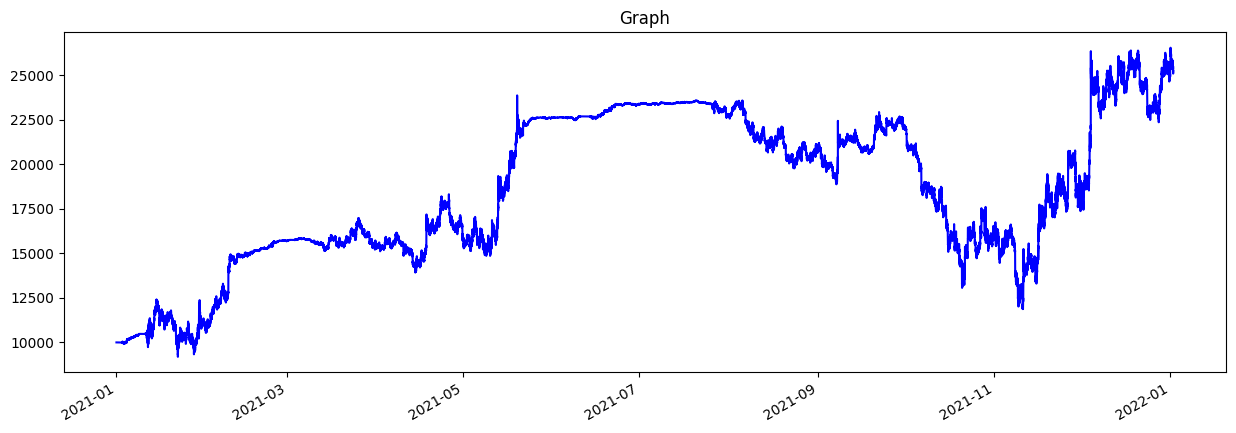

In [22]:
import warnings

# Set the warning filter to "ignore"
warnings.filterwarnings("ignore")

instance= BackTest(data['2021-01-01':'2022-01-01'], model8)
instance.backtest()

warnings.filterwarnings("default")

In [23]:
model8.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_109 (Dense)           (None, 128)               5120      
                                                                 
 batch_normalization_81 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_81 (Dropout)        (None, 128)               0         
                                                                 
 dense_110 (Dense)           (None, 64)                8256      
                                                                 
 batch_normalization_82 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_82 (Dropout)        (None, 64)              

In [ ]:
back_test['new_date'] = pd.to_datetime(back_test['datetime'],format="%Y-%m-%d %H:%M:%S", errors="coerce")
def split_date(x):
    list=str(x).split('.')
    return pd.to_datetime(list[0],format="%Y-%m-%d %H:%M:%S");

null_index_values = back_test[back_test['new_date'].isnull()]
null_index_values['new_date']=null_index_values['new_date'].apply(split_date);
back_test[back_test['new_date'].isnull()]=null_index_values
back_test.dtypes
back_test.index=back_test['new_date']
# back_test['datetime']=back_test['date']

In [ ]:
back_test

In [ ]:
back_test=back_test[back_test.index > '2022-01-01']
back_test=create_features(back_test)
back_test=create_more_features(back_test)

In [ ]:
back_test.dropna(inplace=True)
back_test.replace([np.inf, -np.inf], np.nan, inplace=True)
back_test.fillna(method='ffill', inplace=True)
back_test.head()

In [ ]:
back_test